# Quantifying a Stellar Sample in the DP0 Catalogs

**S. Mau**, **A. Drlica-Wagner**

Adapted from "Looking at the "Object Catalogs": merged tract-patch catalogs in DC2 Run 1.1p" by **Michael Wood-Vasey** ([@wmwv](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@wmwv)), with a version last verified to run: **2018-07-24**

In [21]:
import os

import numpy as np

%matplotlib inline 
import matplotlib.pyplot as plt

import pandas as pd

# Astropy
from astropy import units as u
from astropy.coordinates import SkyCoord

import healpy as hp

import fitsio as fits

In [2]:
# Import the Rubin TAP service utilities
from rubin_jupyter_utils.lab.notebook import get_tap_service, retrieve_query

# Get an instance of the TAP service
service = get_tap_service()
assert service is not None
assert service.baseurl == "https://data.lsst.cloud/api/tap"

# Define our reference position on the sky and cone radius in arcseconds
# to use in all following examples
coord = SkyCoord(ra=62.0*u.degree, dec=-37.0*u.degree, frame='icrs')
radius = 1. * u.deg

query = f"""
    SELECT
        obj.objectId, obj.ra, obj.dec,
        obj.mag_g, obj.mag_r, obj.mag_i,
        obj.magerr_g, obj.magerr_r, obj.magerr_i,
        obj.tract, obj.patch, obj.extendedness, 
        obj.good, obj.clean,
        truth.mag_r as truth_mag_r, truth.match_objectId, 
        truth.flux_g, truth.flux_r, truth.flux_i, truth.truth_type,
        truth.match_sep
    FROM dp01_dc2_catalogs.object as obj
    JOIN dp01_dc2_catalogs.truth_match as truth
    ON truth.match_objectId = obj.objectId
    WHERE CONTAINS(POINT('ICRS', obj.ra, obj.dec),CIRCLE('ICRS', {coord.ra.value}, {coord.dec.value}, {radius.value})) = 1
    AND truth.match_objectId >= 0 
    AND truth.is_good_match = 1
"""

query_truth = f"""
    SELECT
        truth.match_objectId, truth.ra, truth.dec,
        truth.mag_r as truth_mag_r,
        truth.tract, truth.patch,
        truth.flux_g, truth.flux_r, truth.flux_i, truth.truth_type,
        truth.match_sep
    FROM dp01_dc2_catalogs.truth_match as truth
    WHERE CONTAINS(POINT('ICRS', truth.ra, truth.dec),CIRCLE('ICRS', {coord.ra.value}, {coord.dec.value}, {radius.value})) = 1
"""
    
print(query)

# For more detailed analysis of results, converting
# to a pandas dataframe is often very useful
df = service.search(query).to_table().to_pandas()
df_truth = service.search(query_truth).to_table().to_pandas()

/tmp/ipykernel_690/1160835803.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) get_tap_service. (Please use lsst.rsp.get_tap_service())
  service = get_tap_service()



    SELECT
        obj.objectId, obj.ra, obj.dec,
        obj.mag_g, obj.mag_r, obj.mag_i,
        obj.magerr_g, obj.magerr_r, obj.magerr_i,
        obj.tract, obj.patch, obj.extendedness, 
        obj.good, obj.clean,
        truth.mag_r as truth_mag_r, truth.match_objectId, 
        truth.flux_g, truth.flux_r, truth.flux_i, truth.truth_type,
        truth.match_sep
    FROM dp01_dc2_catalogs.object as obj
    JOIN dp01_dc2_catalogs.truth_match as truth
    ON truth.match_objectId = obj.objectId
    WHERE CONTAINS(POINT('ICRS', obj.ra, obj.dec),CIRCLE('ICRS', 62.0, -37.0, 1.0)) = 1
    AND truth.match_objectId >= 0 
    AND truth.is_good_match = 1



In [3]:
print(len(df), "objects")

1501582 objects


In [4]:
print(len(df_truth), "truth objects")

6887900 truth objects


# Paramaterization of completeness function and magnitute uncertainty

# Select good stars

In [5]:
# Matched objects passing S/N threshold
snr_threshold = 5
mag_err_threshold = 1/snr_threshold
good_snr = df[(df['magerr_g'] < mag_err_threshold) & (df['magerr_r'] < mag_err_threshold)]

In [6]:
# Matched objects with truth class of stars
true_stars = df[df['truth_type'] == 2]

In [7]:
# Matched objects classified as stars (and galaxies)
safe_max_extended = 1.0
stars = good_snr[good_snr['extendedness'] < safe_max_extended]
galaxies = good_snr[good_snr['extendedness'] >= safe_max_extended]

In [8]:
# Matched objects correctly classified as stars
match_stars_class = stars[np.in1d(stars['objectId'],true_stars['objectId'])]

# True stars
truth_stars = df_truth[df_truth['truth_type'] == 2]

/tmp/ipykernel_690/3346687629.py:19: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(centers, nstar_class/ntot_true_star, label='stellar classification eff')  # matched objects correctly classified as stars / matched objects with truth class of stars


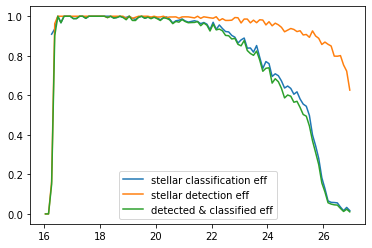

In [9]:
bins = np.linspace(16,27,100)
centers = (bins[1:]+bins[:-1])/2.

# Counts of true stars
ntot_truth, _ = np.histogram(truth_stars['truth_mag_r'],bins=bins)

# Counts of matched objects
ntot, _ = np.histogram(df['truth_mag_r'],bins=bins)

# Counts of matched objects classified as stars
ntot_star, _ = np.histogram(stars['truth_mag_r'],bins=bins)

# Counts of matched objects with truth class of stars
ntot_true_star, _ = np.histogram(true_stars['truth_mag_r'],bins=bins)

# Counts of matched objects correctly classified as stars
nstar_class,_ = np.histogram(match_stars_class['truth_mag_r'],bins=bins)

plt.plot(centers, nstar_class/ntot_true_star, label='stellar classification eff')  # matched objects correctly classified as stars / matched objects with truth class of stars
plt.plot(centers, ntot_true_star/ntot_truth, label='stellar detection eff')  # matched objects with truth class of stars / true stars
plt.plot(centers, nstar_class/ntot_truth, label='detected & classified eff')  # matched objects correctly classified as stars / true stars
plt.legend()

# SM: note that if `mag_r` is used instead of `truth_mag_r`, then some of the
#     bins will have values above 1 due to inaccurate mag measurements

In [20]:
print("mag, stellar classification eff, stellar detection eff, detected & classified eff")
out = np.array([centers,
                nstar_class/ntot_true_star,
                ntot_true_star/ntot_truth,
                nstar_class/ntot_truth]).T
# print(out)
np.savetxt('eff.csv', out, delimiter=',', header='mag,classifiction_eff,detection_eff,classification_detection_eff')

mag, stellar classification eff, stellar detection eff, detected & classified eff


/tmp/ipykernel_690/2394372331.py:3: RuntimeWarning: invalid value encountered in true_divide
  nstar_class/ntot_true_star,


In [29]:
maglim_r = hp.read_map('/home/sidneymau/WORK/satsim/supreme_dc2_dr6d_v3_r_maglim_psf_wmean.fits.gz')

In [50]:
# find the maglim at the point we queried. we'll want to do this more dynamically in the future...
maglim_r[hp.ang2pix(4096, 62, -37, lonlat=True)]

26.791002

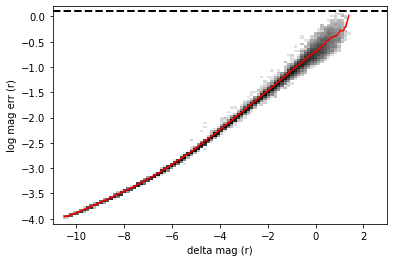

In [56]:
delta_mag_r = np.histogram(true_stars['truth_mag_r']-maglim_r[hp.ang2pix(4096, 62, -37, lonlat=True)], bins=100)[1]
indices = np.digitize(true_stars['truth_mag_r']-maglim_r[hp.ang2pix(4096, 62, -37, lonlat=True)], delta_mag_r)
magerr_r = np.asarray([np.nanmedian(true_stars['magerr_r'][indices == idx]) for idx in np.unique(indices)])

from matplotlib.colors import LogNorm
# we are using `truth_mag_r` because we're using these photometric error models
# to generate simulations which will then be used to generate realistic photometry
plt.hist2d(true_stars['truth_mag_r']-maglim_r[hp.ang2pix(4096, 62, -37, lonlat=True)],np.log10(true_stars['magerr_r']),bins=100,norm=LogNorm(),range=[[-11, 3], [-4.1, 0.2]], cmap='binary')
plt.plot(delta_mag_r, np.log10(magerr_r), c='r')
plt.xlabel('delta mag (r)'); plt.ylabel('log mag err (r)')
plt.axhline(0.1085,ls='--',color='k',lw=2)

In [52]:
print("delta_mag, log_mag_err")
out = np.array([delta_mag_r,
                np.log10(magerr_r)]).T
# print(out)
np.savetxt('phot.csv', out, delimiter=',', header='delta_mag,log_mag_err')

delta_mag, log_mag_err
